**Relevant reading for this problem set**:
<a href="https://moderndive.com/8-confidence-intervals.html"
target="_blank">ModernDive Chapter 8: Bootstrapping and Confidence
Intervals</a>.

## Background

In this problem set we will use a small **sample** of data from the
[General Social Survey](http://gss.norc.org/). The survey is designed to
monitor changes in both social characteristics and attitudes. You will
work with a **sample** from one neighborhood. The full neighborhood of
**ALL individuals** is the population. For this problem set we do
**not** know the **true population parameters** for any of the
variables, because we do not have data on every person in the
neighborhood.

## Setup

First load the necessary packages

In [1]:
# Recall that loading the tidyverse "umbrella" package loads ggplot2, dplyr, and
# readr all at once. Feel free to load these packages any way you choose.
library('tidyverse')
library('moderndive')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next load the data set, from where it is stored on the web:

In [2]:
gss_sample = read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSypSoDCMH2N76Vo2dZRPkw2q3t1mbvAXlOtgPDIsHg4NclAQFmER-BdvXH9_lrT40UQCVdPXOi_NMJ/pub?gid=257689625&single=true&output=csv", col_types = cols())

gss_sample |> glimpse()

Rows: 100
Columns: 3
$ age     <dbl> 79, 23, 31, 53, 39, 59, 45, 84, 52, 60, 21, 25, 56, 68, 58, 42…
$ race    <chr> "White", "White", "POC", "White", "White", "White", "White", "…
$ tvhours <dbl> 1, 1, 4, 4, 1, 1, 2, 3, 4, 3, 0, 3, 1, 3, 4, 1, 1, 2, 1, 5, 2,…


Be sure to take a look at the data in the **viewer**. Each row in the
data set is a person that was surveyed (100 rows or cases in total). The
variables in the data set include each respondent’s `age`, `race`, and
number of hours of TV watched a day `tvhours`.

**Setting a seed:** We will take some random samples and build sampling
distributions in this lab. In order to make sure R takes the same random
sample every time you run your code, you can do what is called “setting
a seed”. Do this in any code chunk that you take a random sample!

You can set a seed like so. Any number will do. (You do not need to run
this right now…just showing you how)

In [3]:
set.seed(45)

# Confidence intervals from a bootstrap resample

### Step 1: Take 1000 bootstrap resamples

The following code tells R to take 1000 bootstrap resamples from the
`gss_sample` data. You can set the seed to whatever value you like!

In [4]:
set.seed(42)

boot_samp_1000 = gss_sample |> 
  rep_sample_n(size = 100, reps = 1000, replace = TRUE)

boot_samp_1000 |> head()

replicate,age,race,tvhours
<int>,<dbl>,<chr>,<dbl>
1,37,POC,2
1,27,POC,5
1,76,White,0
1,25,White,0
1,67,White,2
1,20,White,2


In [5]:
boot_samp_1000 |> tail()

replicate,age,race,tvhours
<int>,<dbl>,<chr>,<dbl>
1000,22,White,5
1000,54,POC,4
1000,80,White,8
1000,22,White,5
1000,46,White,1
1000,27,White,1


Note a few important details about the `rep_sample_n` function, and
bootstrap sampling in general:

-   `size = 100` tells R that each bootstrap resample we take has 100
    cases… the size of the original sample
-   `reps = 1000` tells R to take 1000 bootstrap resamples (each of size
    100).
-   The `replace = TRUE` argument tells R that in each bootstrap
    resample, we can include a row from `gss_sample` multiple times. So
    if for instance, respondent \# 12 is the first random resample taken
    here, respondent 12 is still available to be resampled **again** at
    random. Thus, some people may appear **multiple times** in our
    bootstrap resample, and some people from the original data set may
    not appear at all.
-   We save the results in a data frame `boot_samp_1000`.

Take a look at the `boot_samp_1000` data frame we just generated in
RStudio’s data viewer. Note that the `replicate` column labels each
bootstrap resample (the first 100 rows are labeled 1, the next 100 rows
are labeled 2, etc.)

## Question 1

How many rows does `boot_samp_1000` have? **Why?**

**Answer:**

There are 100,000 rows in `boot_samp_1000` because a random sample of size 100 (n = 100) is taken and such a sample is taken over and over for 1,000 repetitions (r = 1,000).
🧮 n * r = 100,000

In [6]:
boot_samp_1000 |> glimpse()

Rows: 100,000
Columns: 4
Groups: replicate [1,000]
$ replicate <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ age       <dbl> 37, 27, 76, 25, 67, 20, 37, 79, 33, 49, 67, 41, 40, 61, 40, …
$ race      <chr> "POC", "POC", "White", "White", "White", "White", "POC", "Wh…
$ tvhours   <dbl> 2, 5, 0, 0, 2, 2, 2, 5, 1, 3, 2, 1, 2, 5, 3, 4, 4, 1, 2, 1, …


### Step 2: Calculate the bootstrap statistic

Let’s say we want to use the bootstrap resample that we just generated
to calculate a confidence interval for the population mean $\mu_{tv}$ of
`tvhours`. To do so, we need to know the sample mean $\bar{x}$ of
`tvhours` **for each of the 1000 bootstrap resamples**. In this case,
the sample mean $\bar{x}$ of `tvhours` for **each bootstrap resample**
is our **BOOTSTRAP STATISTIC**. We can calculate that with two lines of
code, like so:

In [7]:
boot_distrib_tv = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat = mean(tvhours))

boot_distrib_tv |> head()

replicate,boot_stat
<int>,<dbl>
1,2.72
2,3.45
3,2.96
4,2.80
5,3.16
6,2.77


Note that:

-   The `group_by()` argument tells R to take the sample mean of
    `tvhours` **separately** for each different `replicate` in the
    bootstrap resample.
-   We put the sample mean for each bootstrap resample in a column
    called `boot_stat`

> This is the bootstrap distribution for the mean of `tvhours`!

Take a look at the `boot_distrib_tv` we just created in RStudio’s data
viewer.

In [8]:
boot_distrib_tv |> tail()

replicate,boot_stat
<int>,<dbl>
995,2.98
996,3.57
997,3.05
998,3.75
999,3.09
1000,3.25


## Question 2

How many values of the bootstrap statistic `boot_stat` are there? Please
explain **why** there are this many values of the bootstrap statistic.

**Answer:**

There are 1,000 values of the bootstrap statistic `boot_stat` because there is a value for each of the 1,000 iterations 🔁 performed by rep_sample_n(). 

### Visualizing the bootstrap distribution

Make a histogram of the `boot_stat` values from `boot_distrib_tv`.

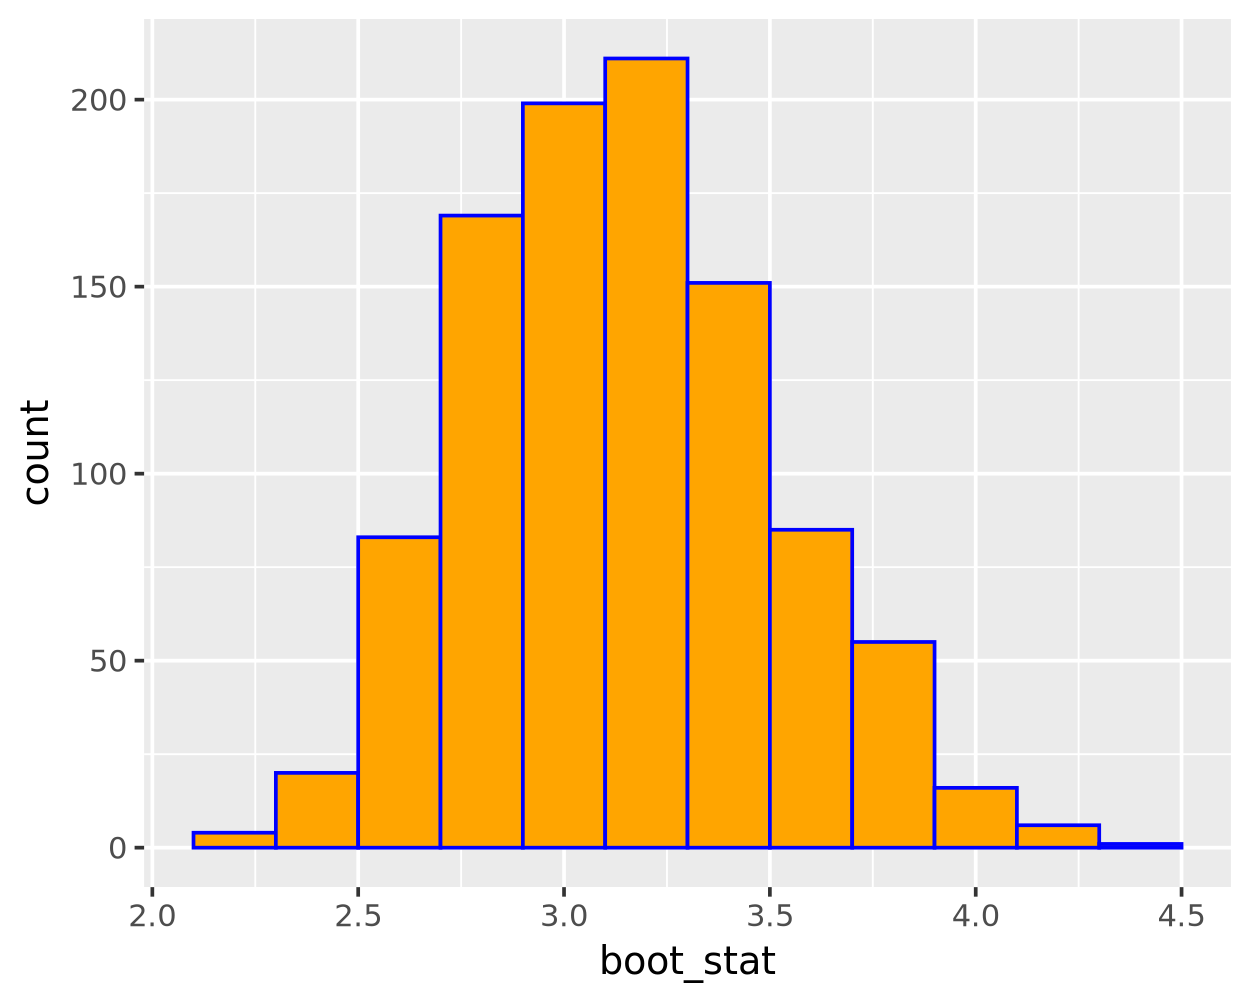

In [24]:
boot_distrib_tv |>
  ggplot(aes(x=boot_stat)) +
  geom_histogram(binwidth = 0.20, color="blue", fill="orange")

### Step 3: CI from a bootstrap resample

### a) CI using the 95% rule

We can now use the bootstrap distribution for the sample mean `tvhours`
$\bar{x}$ to calculate a 95% confidence interval for the population mean
`tvhours` $\mu_{tv}$, using the “95% rule for bell shaped
distributions”, which states that the middle 95% of values of a
bell/normal shaped distribution are between

$$\text{mean} \pm 1.96 \cdot SD$$

-   the mean here would be the mean of the bootstrap distribution
-   the SD here is the standard deviation of the bootstrap distribution,
    which recall has a special name: the **standard error**.

We can thus apply the 95% rule, like so:

In [25]:
boot_distrib_tv |>
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
3.14418,0.3651603,2.428466,3.859894


### b) CI using percentile method

You can also calculate a 95% confidence interval using the percentile
method. The logic goes like this:

Since our bootstrap resample had 1000 values of `boot_stat`:

1.  950 of the `boot_stat` values fall **inside** this 95% confidence
    interval, i.e. 95%
2.  25 values fall **below** it. i.e. the lower 2.5%
3.  25 values fall **above** it. i.e. the higher 2.5%

totaling 100%. We can use **the quantiles** of the bootstrap
distribution to find these values like so:

In [26]:
prct_ci_tv = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

prct_ci_tv

lower_ci,upper_ci
<dbl>,<dbl>
2.51,3.89


This method

-   Asks R to identify the 0.025 quantile of the bootstrap sample means…
    this is the value **below** which **2.5% of the values of
    `boot_stat`** fall (or 25 cases in this example… 25/1000 = 0.025)
-   Asks R to identify the 0.975 quantile for the bootstrap sample
    means… this is the value **above** which the other **2.5% of the
    values of `boot_stat`** fall (or 25 cases in this example 975/1000 =
    0.975)
-   The middle 95% of the values fall between these two quantiles

Based on these results, we are 95% confident that the **true mean hours
of TV watched $\mu_{tv}$ in the population** is between the upper and
lower CI we just calculated.

### Visualizing the Confidence interval

Display the bootstrap distribution and the 95% confidence intervals we just
calculated below. 

1. Make a histogram of the `boot_stat` values from `boot_distrib_tv`.
2. Add a green line for the lower bound of the 95% CI, and,
3. a blue line fir the upper bound.
 
950 of the 1000 bootstrap resamples had a mean for `tvhours` that fell **between**
the green and blue lines…25 of the samples had a mean above the blue
line, and 25 of the samples had a mean below the green line.

In [48]:
# color time 🌈

# colorBottom = "#264027"
# colorTop = "#39A0ED"
# colorLine = "#EFD0CA"
# colorFill = "#979B8D"

# colorBottom = "#60A561"
# colorTop = "#39A0ED"
# colorLine = "#E6E6E9"
# colorFill = "#553555"

colorBottom = "#60A561"
colorTop = "#39A0ED"
colorLine = "#F7F7FF"
colorFill = "#C49991"

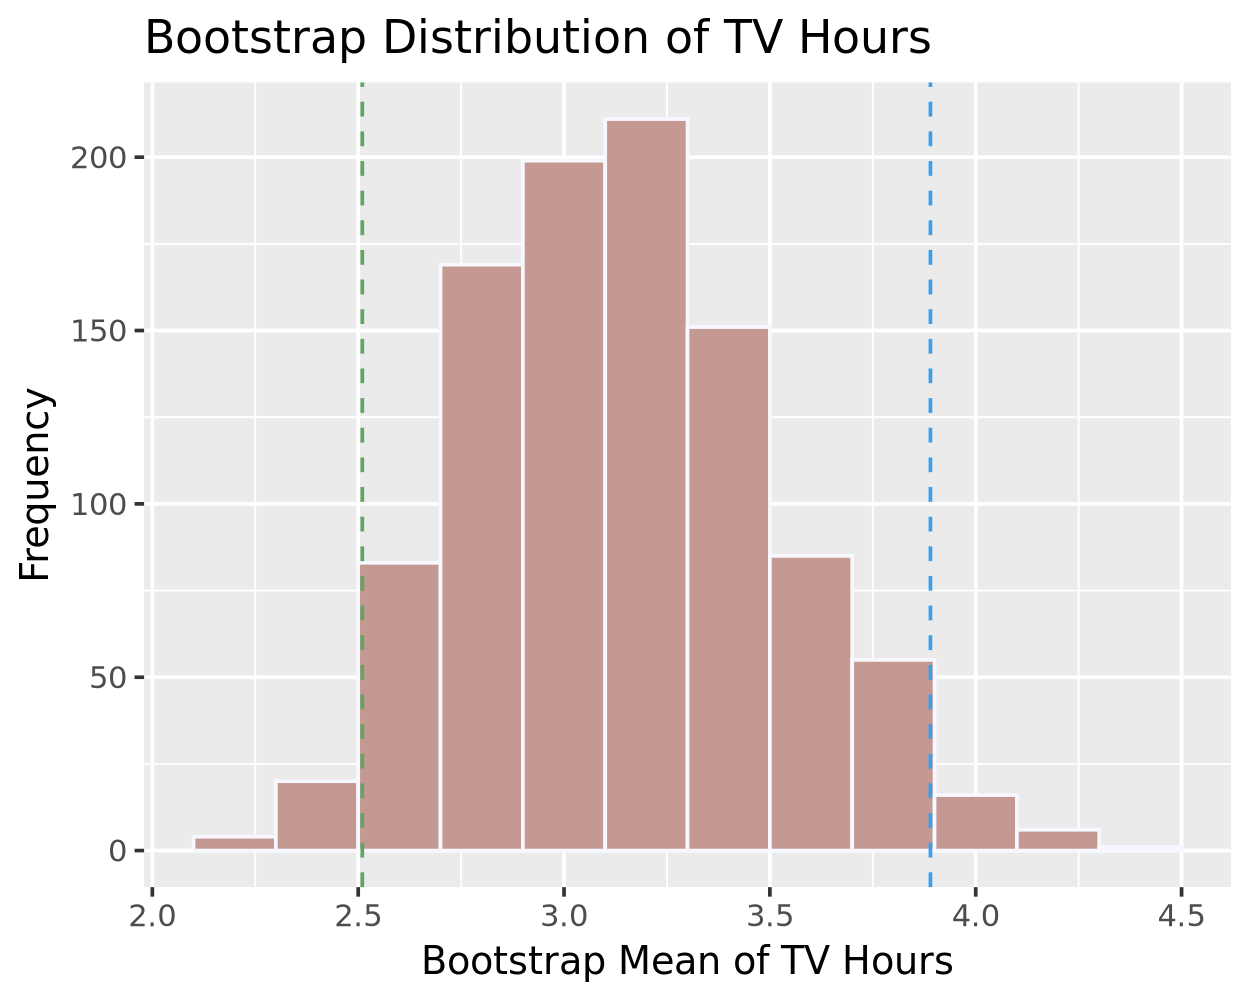

In [49]:
boot_distrib_tv |>
  ggplot(aes(x=boot_stat)) +
  geom_histogram(binwidth = 0.20, color=colorLine, fill=colorFill) +
  geom_vline(data=prct_ci_tv, aes(xintercept = lower_ci), color = colorBottom, linetype = "dashed") +
  geom_vline(data=prct_ci_tv, aes(xintercept = upper_ci), color = colorTop, linetype = "dashed") +
  labs(title = "Bootstrap Distribution of TV Hours", x = "Bootstrap Mean of TV Hours", y = "Frequency")

## Question 3

**If** we calculated a **90% confidence interval** for the mean of
`tvhours` using this same bootstrap resample and the percentile method,
roughly how many of the 1000 values of `tv_mean` would fall between the
green and blue lines?

**Answer:**

Calculating a **90% confidence interval** would mean that we expect 90% of the values would fall between the green and blue lines, with 50 values below the green line and 50 values above the blue line.

## Question 4

Use the bootstrap resampling distribution for `tvhours` generated above
(`boot_distrib_tv`) and the **percentile** method to calculate a 99%
confidence interval for the mean `tvhours`.

In [50]:
prct_99_ci_tv = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.005), 
            upper_ci = quantile(boot_stat, 0.995))

In [52]:
prct_99_ci_tv

lower_ci,upper_ci
<dbl>,<dbl>
2.31995,4.1302


## Question 5

Which confidence interval is **WIDER**: the 95% confidence interval or
the 99% confidence interval for the population mean `tvhours`
$\mu_{tv}$? Why is this the case? Answer in terms of the trade-off
between confidence level and confidence interval width.

**Answer:**

The **WIDER** confidence interval is the **99% confidence interval**. This is because we are including more values in this interval - the bottom and top ranges are extended to incorporate more values, and this is the trade-off - you have a higher confidence level but you have to include a wider range of values.

## Question 6.a)

Use the bootstrap resample we generated above (`boot_samp_1000`), to
generate a **bootstrap distribution** for the sample mean respondent
`age` $\bar{x}$ instead of `tvhours`. Please be sure to **name it
something different** than the bootstrap distribution for the sample
mean of `tvhours`

In [53]:
boot_distrib_age = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat_age = mean(age))

In [54]:
boot_distrib_age |> head()

replicate,boot_stat_age
<int>,<dbl>
1,47.12
2,49.01
3,45.54
4,47.06
5,46.11
6,46.85


## Question 6.b)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **95% rule** method.

In [55]:
boot_distrib_age |>
  summarize(mean = mean(boot_stat_age), 
            se = sd(boot_stat_age), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
47.60143,1.673659,44.32106,50.8818


## Question 6.c)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **percentile** method.

In [56]:
boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat_age, 0.025), 
            upper_ci = quantile(boot_stat_age, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
44.47,50.97075


## Question 6.d)

How do the 95% confidence intervals you calculated in 6b and 6c compare?
i.e. are the 95% CI values similar or are they pretty different?

**Answer:**

The values are quite similar. Using each method produced lower_ci and upper_ci values within a tenth of each other.

## Question 7

Use the **bootstrap resampling distribution** for the sample mean
respondent `age` and the percentile method to calculate an 80%
confidence interval for the population mean respondent age $\mu_{age}$.

In [57]:
# 80% confidence interval

boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat_age, 0.10), 
            upper_ci = quantile(boot_stat_age, 0.90))

lower_ci,upper_ci
<dbl>,<dbl>
45.49,49.681


# Bootstrap sampling distribution & confidence intervals with categorical variables

The procedure for generating a bootstrap sampling distribution is VERY
similar for categorical data. As an example we will generate a bootstrap
sampling distribution for the proportion of respondents that identified
as a Person of Color.

### Step 1: Take 1000 bootstrap resamples

We already did this above! We can use the same `boot_samp_1000` as
before.

### Step 2: Calculate the bootstrap statistic $\hat{p}$

In [58]:
boot_distrib_POC = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            POC_count = sum(race == "POC"), 
            boot_stat = POC_count/n)

boot_distrib_POC |> head()

replicate,n,POC_count,boot_stat
<int>,<int>,<int>,<dbl>
1,100,26,0.26
2,100,24,0.24
3,100,25,0.25
4,100,16,0.16
5,100,28,0.28
6,100,22,0.22


Note that with a categorical variable, the code differs in two important
respects now:

-   the population parameter that we don’t know, but are inferring about
    via sampling, is now the population proportion $p$ that identify as
    a POC.
-   the sample statistic AKA point estimate that we calculate with the
    summarize command is now the **sample proportion** $\widehat{p}$
    rather than a sample mean $\bar{x}$
-   To get our proportion $\widehat{p}$ of **ONE** of the race
    categories (POC), we need to **first** calculate the total sample
    size for each replicate and the count of how many cases are
    `race == "POC"` in each replicate.

### Step 3: Generate the 95% Confidence Interval

### a) CI using the 95% rule

The following will calculate the 95% confidence interval for the
proportion of people that identified as `POC` using the 95% rule.

In [59]:
boot_distrib_POC |> 
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.24053,0.04213543,0.1579446,0.3231154


### b) CI with the percentile method

The following will calculate the 95% confidence interval for the
proportion of people that identified as “POC” using the percentile
method.

In [60]:
boot_distrib_POC |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.16,0.33


## Question 8

Calculate a 95% CI for the **population proportion** of respondents $p$
that identified as **White** using EITHER the percentile or 95% rule
method. Note that you will first need to generate the bootstrap
distribution for the proportion of respondents that identified as
`White`.

In [61]:
# First generate the bootstrap distribution for the proportion of respondents that identified as White

boot_distrib_White = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            White_count = sum(race == "White"), 
            boot_stat = White_count/n)

In [63]:
# Using the percentile method to calculate a 95% CI

boot_distrib_White |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.67,0.84


# Confidence intervals based on the theoretical normal distribution

As described in [moderndive chapter
8.7.2](https://moderndive-bert.netlify.com/8-confidence-intervals.html#theory-ci),
not only can we generate confidence intervals using a
computer/resampling as we’ve been doing until now, in many cases there
also exists a mathematical formula! This however necessitates a little
mathematical/probability theory; a topic we leave to a more advanced
statistics class.

To generate a 95% confidence interval based on the theoretical normal
distribution, we can use the following formula:

$$ \text{point estimate} \pm 1.96 \cdot \widehat{SE}$$

So, for instance if we wanted to calculate the 95% confidence interval
for the population mean of `tvhours` $\mu_{tv}$ that respondents watched
based on our sample:

-   the **point estimate** AKA **sample statistic** in this case would
    be the sample mean number of `tvhours` from the sample: $\bar{x}$
-   We would estimate the standard error using the formula

$$\widehat{SE} \approx \frac{s}{\sqrt{n}}$$

where $s$ is the **sample standard deviation**, which is a point
estimate of the **population standard deviation** $\sigma$.

Thus a 95% CI would be

$$
\bar{x} \pm 1.96 \cdot \widehat{SE} =  \bar{x} \pm 1.96 \cdot \frac{s}{\sqrt{n}}
$$

We can make these calculations in R like so:

In [64]:
gss_sample |> 
  summarize(x_bar = mean(tvhours), 
            sd = sd(tvhours), 
            n = n(), 
            se = sd/sqrt(n), 
            lower_ci = x_bar - 1.96 * se, 
            upper_ci = x_bar + 1.96 * se)

x_bar,sd,n,se,lower_ci,upper_ci
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
3.14,3.592979,100,0.3592979,2.435776,3.844224


## Question 9

Write down the three 95% confidence intervals for the population mean of
`tvhours` $\mu_{tv}$ you’ve computed in this problem set. Do this by
replacing X, Y, A, B, P, and Q with the appropriate values you’ve
computed.

When you are done, make sure all the `|` in the table still line up so
your results print out in a table!

| CI construction method          | lower value | upper value |
|---------------------------------|-------------|-------------|
| Using boostrap: 95% rule        | 2.428466    | 3.859894    |
| Using boostrap: percentile rule | 2.51        | 3.89        |
| Using mathematical formula      | 2.435776    | 3.844224    |

In [65]:
gss_sample |>
  summarize(max = max(tvhours),
            min = min(tvhours)
            )

max,min
<dbl>,<dbl>
24,0


In [67]:
gss_sample |>
  group_by(tvhours) |>
  summarize(count = n())

tvhours,count
<dbl>,<int>
0,10
1,25
2,20
3,12
4,17
5,6
6,2
8,3
10,1


In [69]:
gss_sample |>
  filter(tvhours == 24) |>
  select(age)

age
<dbl>
31


## Question 10

**In your opinion**, would you say these three confidence intervals are
similar?

**Answer:**

Yes, they are similar. The spread of responses to the question `number of hours of TV watched daily` is 0-24.

True, one pitiful soul responded `24 hours of TV watched daily`. A 31-year old!